In [2]:
import torch
from torch import nn
from torch.nn import functional as F

## Loss functions

### Mse loss

In [10]:
pred = torch.randn((3, 5))
print("pred:", pred)

label = torch.randn(3, 5)
print("label:", label)

pred: tensor([[ 1.2464, -1.1232,  0.8636, -1.5812, -1.1793],
        [ 0.8593, -0.2286, -0.3542, -0.1295,  0.7239],
        [-1.3804, -0.3531,  0.0339,  0.3228, -0.4172]])
label: tensor([[ 3.8113e-04,  2.0882e-01,  2.8640e-01,  5.2145e-01, -9.3060e-01],
        [ 5.8831e-01,  4.5648e-01, -1.8834e+00, -9.0287e-01, -3.7019e-02],
        [ 2.3802e-01, -2.0370e+00, -1.5532e-01, -1.7764e+00, -8.2438e-01]])


In [11]:
loss_fn = nn.MSELoss()
loss = loss_fn(pred, label)
print("MSE loss:", loss)

MSE loss: tensor(1.4843)


### Cross-Entropy loss

In [14]:
pred = torch.randn((3, 5))
print("pred:", pred)

label = torch.empty(3, dtype=torch.long).random_(5)
print("label:", label)

pred: tensor([[ 1.5124,  0.4150,  2.0578,  0.6933, -1.6977],
        [ 0.8296, -0.9106,  0.2031,  1.8563, -1.0071],
        [ 2.0252,  1.0455,  0.1639,  0.1877, -0.9732]])
label: tensor([0, 1, 2])


In [16]:
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(pred, label)
print("CE loss:", loss)

CE loss: tensor(2.3196)


### Focal loss

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, 
                alpha=0.25,
                gamma=2,
                num_classes=2,
                reduction="mean"):
        """Focal loss function.
        -α(1-pt)**γ *log(pt)

        Args:
            alpha (float|list[float]): a weighting factor for class imbalancing.
                                       Default: 0.25 in RetinaNet.
                                       If a list of float is given, 
                                       each element is the weighting factors for each class.
            gamma (float): a focusing factor for addressing easy/hard examples. 
                           Default: 2 in RetinaNet.
            num_classes (int): number of classes. Default: 2.
            reduction (str): reduction method: 'mean'|'sum'. Default: 'mean'
        """
        super(FocalLoss, self).__init__()
        assert reduction == 'mean' or reduction == 'sum'
        self.reduction = reduction
        if isinstance(alpha,list):
            assert len(alpha)==num_classes
            self.alpha = torch.Tensor(alpha)
        else:
            assert alpha<1
            self.alpha = torch.zeros(num_classes)
            self.alpha[0] += alpha
            self.alpha[1:] += (1-alpha) # α = [ α, 1-α, 1-α, 1-α, 1-α, ...] size:[num_classes]

        self.gamma = gamma
    
    def forward(self, preds, labels):
        """
        Calculate Focal loss
        Args:
            preds (torch.Tensor): The prediction. Shape:[B,N,C] or [B,C]
            labels (torch.Tensor): The learning label of the prediction. Shape:[B,N] or [B]
        Return:
            loss (torch.Tensor): The loss.
        """
        preds = preds.view(-1, preds.size(-1))
        self.alpha = self.alpha.to(preds.device)
        preds_logsoft = F.log_softmax(preds, dim=1) # log_softmax: log(pt)
        preds_softmax = torch.exp(preds_logsoft)    # softmax: pt

        # Gather the values from the corresponding label indexes
        preds_softmax = preds_softmax.gather(1,labels.view(-1,1))
        preds_logsoft = preds_logsoft.gather(1,labels.view(-1,1))
        self.alpha = self.alpha.gather(0,labels.view(-1))

        loss = -(1-preds_softmax)**self.gamma * preds_logsoft  # -(1-pt)**γ *log(pt)
        loss = self.alpha * loss.T

        if self.reduction =="mean":
            loss = loss.mean()
        elif self.reduction =="sum":
            loss = loss.sum()
        return loss

In [22]:
pred = torch.randn((3,5))
print("pred:",pred)

label = label = torch.empty(3, dtype=torch.long).random_(5)
print("label:",label)

pred: tensor([[ 1.5279,  1.0961, -1.4169,  0.5759,  1.5337],
        [-1.1159, -1.1791,  0.8304,  1.1228,  0.7290],
        [-0.4817,  1.7788, -1.2541, -1.3230, -0.9190]])
label: tensor([4, 0, 3])


In [25]:
loss_fn = FocalLoss(alpha=[1,2,3,1,2], gamma=2, num_classes=5)
loss = loss_fn(pred, label)
print(loss)

tensor(2.3591)


# Train a simple neural network

## 1. Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Split the dataset into two groups: training and validation datasets (5000 images, 10% of the dataset).

In [3]:
torch.manual_seed(43)
val_size = 2000
train_size = len(dataset) - val_size

In [4]:
from torch.utils.data import random_split

trainset, valset = random_split(dataset, [train_size, val_size])
len(trainset), len(valset)

(48000, 2000)

In [5]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(valset, batch_size, shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Show some of the training images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


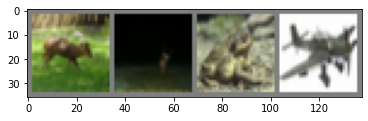

deer deer frog plane


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images[:4]))
# print labels
print(' '.join('%s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. Define a loss function and optimizer

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network

In [9]:
from tqdm.auto import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

logging_interval = 2000

for epoch in range(5):  # loop over the dataset multiple times

    running_train_loss = 0.0
    net.train()
    for i, data in tqdm(enumerate(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        
        # print statistics
        if i % logging_interval == logging_interval-1:
            print(f'[Epoch:{epoch + 1}, Iter:{i+1}] training loss: {running_train_loss / logging_interval:.5f}')
            running_train_loss = 0.0
    
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    net.eval()
    with torch.no_grad():

        for i, data in tqdm(enumerate(valloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # forward
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        
        # print statistics
        print(f'[Epoch:{epoch + 1}] validation loss: {val_loss / len(valloader):.5f}')
        val_loss = 0.0
        print(f'Accuracy of the network on the {val_total} val images: {100 * val_correct / val_total}%')

print('Finished Training')

cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch:1, Iter:2000] training loss: 2.15102


0it [00:00, ?it/s]

[Epoch:1] validation loss: 1.74668
Accuracy of the network on the 2000 val images: 35.1%


0it [00:00, ?it/s]

[Epoch:2, Iter:2000] training loss: 1.60750


0it [00:00, ?it/s]

[Epoch:2] validation loss: 1.48489
Accuracy of the network on the 2000 val images: 46.2%


0it [00:00, ?it/s]

[Epoch:3, Iter:2000] training loss: 1.42177


0it [00:00, ?it/s]

[Epoch:3] validation loss: 1.37564
Accuracy of the network on the 2000 val images: 51.15%


0it [00:00, ?it/s]

[Epoch:4, Iter:2000] training loss: 1.30223


0it [00:00, ?it/s]

[Epoch:4] validation loss: 1.28059
Accuracy of the network on the 2000 val images: 53.9%


0it [00:00, ?it/s]

[Epoch:5, Iter:2000] training loss: 1.22476


0it [00:00, ?it/s]

[Epoch:5] validation loss: 1.20950
Accuracy of the network on the 2000 val images: 56.75%
Finished Training


## 4.Test the network on the test data

In [10]:
correct = 0
total = 0
net.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct / total}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 58.81%


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
net.eval()
# again no gradients needed
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname:5} is: {accuracy:.1f}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy for class plane is: 68.4 %
Accuracy for class car   is: 84.2 %
Accuracy for class bird  is: 32.7 %
Accuracy for class cat   is: 28.2 %
Accuracy for class deer  is: 57.8 %
Accuracy for class dog   is: 47.9 %
Accuracy for class frog  is: 74.1 %
Accuracy for class horse is: 64.9 %
Accuracy for class ship  is: 72.2 %
Accuracy for class truck is: 57.7 %
